<a href="https://colab.research.google.com/github/5h33p/graduate_admission2/blob/main/DeepLearning_Graduate_Admission_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [24]:
!pip install kagglehub

In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ETL

In [26]:
path = kagglehub.dataset_download("mohansacharya/graduate-admissions")

# print("Path to dataset files:", path)

dfs = []

for file in os.listdir(path):
    if file.endswith(".csv"):
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

dataset = pd.concat(dfs, ignore_index=True)
# dataset.head()

In [27]:
new_columns = []

for column in dataset.columns:
  new_columns.append(column.lower().strip().replace(' ', '_').replace('.', ''))

dataset.columns = new_columns

features = dataset.drop(columns='chance_of_admit')
labels = dataset.chance_of_admit

# print(features.dtypes)
features.research = features.research.astype('bool')
num_features = features.select_dtypes(['int64', 'float64']).columns
ct = ColumnTransformer([('scaler', StandardScaler(), num_features)], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=8)
X_train_scaled = pd.DataFrame(ct.fit_transform(X_train), columns=ct.get_feature_names_out())
X_test_scaled = pd.DataFrame(ct.fit_transform(X_test), columns=ct.get_feature_names_out())
X_train_scaled.head()

,scaler__serial_no,scaler__gre_score,scaler__toefl_score,scaler__university_rating,scaler__sop,scaler__lor,scaler__cgpa,remainder__research
0,0.490464,-0.087316,-1.071966,-0.976154,-0.920691,-1.646911,-0.472867,1.0
1,-1.436618,1.847065,1.739447,0.772181,-0.411553,1.111990,1.319399,1.0
2,-0.311261,0.879874,0.912561,0.772181,1.115860,1.111990,0.838142,1.0
3,0.666991,0.616095,0.581806,-0.101986,-0.920691,-1.646911,0.323696,1.0
4,-1.061499,0.440243,1.243315,1.646349,0.606722,1.111990,1.253018,1.0


# Creating Regressor Model

In [28]:
model = Sequential()
input = layers.InputLayer(shape=(X_train_scaled.shape[1],))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1))

callback = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)
opt = Adam(learning_rate=0.01)
model.compile(loss='mse', metrics=['mae'], optimizer=opt)

history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=True, callbacks=[callback])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.4593 - mae: 0.5232 - val_loss: 0.0526 - val_mae: 0.1736
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0387 - mae: 0.1530 - val_loss: 0.0188 - val_mae: 0.1039
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0188 - mae: 0.1090 - val_loss: 0.0137 - val_mae: 0.0928
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - mae: 0.0830 - val_loss: 0.0093 - val_mae: 0.0769
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0072 - mae: 0.0655 - val_loss: 0.0063 - val_mae: 0.0625
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0529 - val_loss: 0.0049 - val_mae: 0.0569
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - mae: 0.0454 - val_loss: 0.0044 - val_mae: 0.0511
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - mae: 0.0410 - val_loss: 0.0042 - val_mae: 0.0503
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss

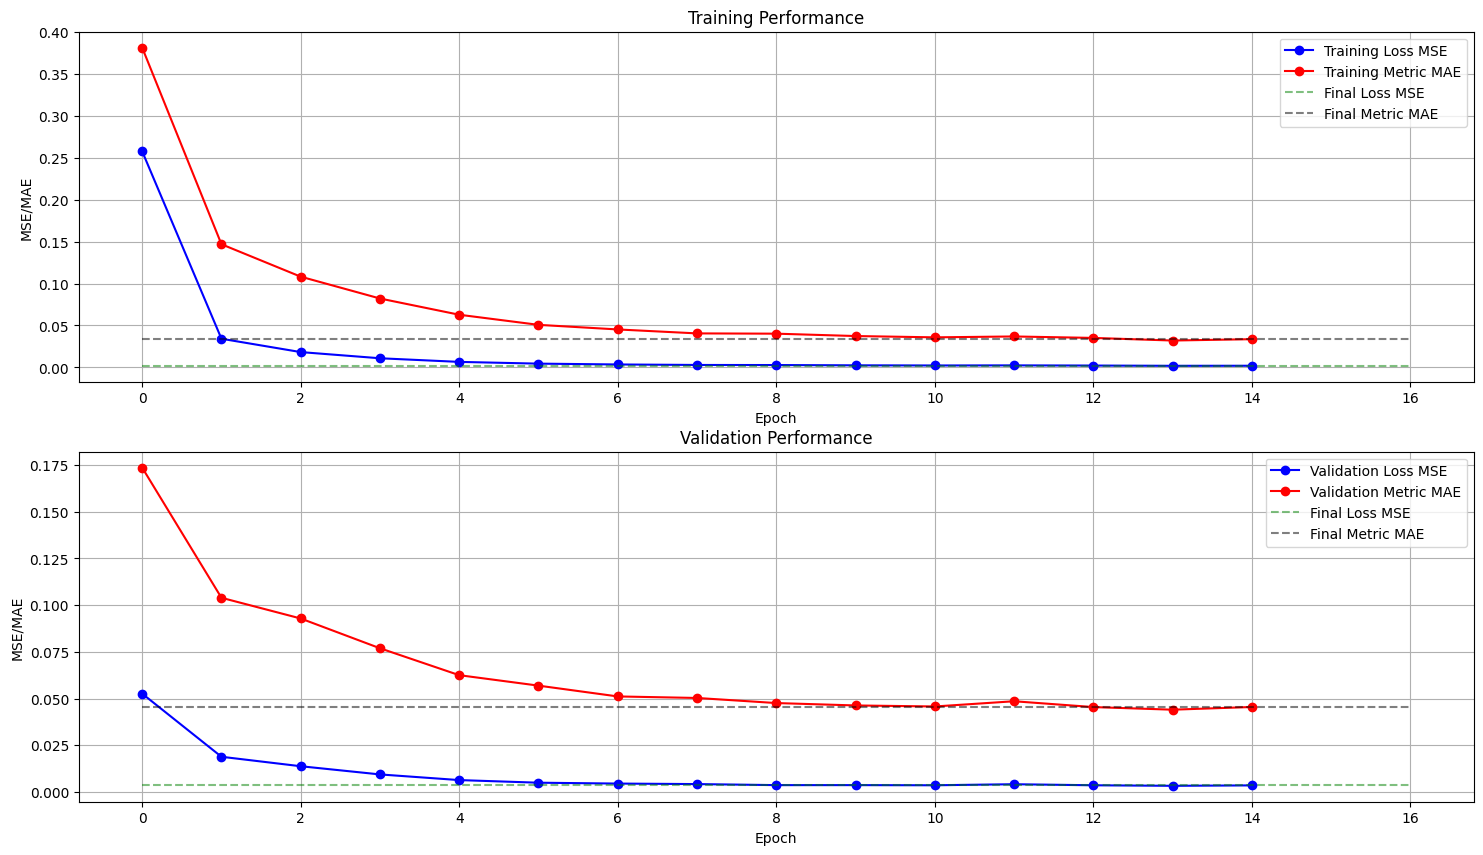

In [29]:
mse_train = history.history['loss']
mae_train = history.history['mae']
mse_val = history.history['val_loss']
mae_val = history.history['val_mae']


X = range(1, len(mse_train) + 1)

fig, axs = plt.subplots(2, 1, figsize=(18, 10))

axs[0].plot(mse_train, '-ob', label='Training Loss MSE')
axs[0].plot(mae_train, '-or', label='Training Metric MAE')
axs[0].hlines(y=mse_train[-1], xmin=0, xmax=len(mse_train) + 1, colors='g', linestyles='--', label='Final Loss MSE', alpha=0.5)
axs[0].hlines(y=mae_train[-1], xmin=0, xmax=len(mae_train) + 1, colors='k', linestyles='--', label='Final Metric MAE', alpha=0.5)
axs[0].grid(True)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('MSE/MAE')
axs[0].set_title('Training Performance')
axs[0].legend()

axs[1].plot(mse_val, '-ob', label='Validation Loss MSE')
axs[1].plot(mae_val, '-or', label='Validation Metric MAE')
axs[1].hlines(y=mse_val[-1], xmin=0, xmax=len(mse_val) + 1, colors='g', linestyles='--', label='Final Loss MSE', alpha=0.5)
axs[1].hlines(y=mae_val[-1], xmin=0, xmax=len(mae_val) + 1, colors='k', linestyles='--', label='Final Metric MAE', alpha=0.5)
axs[1].grid(True)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE/MAE')
axs[1].set_title('Validation Performance')
axs[1].legend()

In [30]:
model.evaluate(X_test_scaled, y_test, return_dict=True)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0479 


{'loss': 0.0044196415692567825, 'mae': 0.0500921793282032}

In [31]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train_scaled, y_train)
dummy_model.score(X_test_scaled, y_test)

-0.023062162072052805

In [32]:
mse_train_dummy = mean_squared_error(y_train, model.predict(X_train_scaled))
mae_train_dummy = mean_absolute_error(y_train, model.predict(X_train_scaled))
# print(f'MSE Train: {mean_squared_error(y_train, model.predict(X_train_scaled))}\nMAE train: {mean_absolute_error(y_train, model.predict(X_train_scaled))}')

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [33]:
mse_test_dummy = mean_squared_error(y_test, model.predict(X_test_scaled))
mae_test_dummy = mean_absolute_error(y_test, model.predict(X_test_scaled))
# print(f'MSE Test: {mean_squared_error(y_test, model.predict(X_test_scaled))}\nMAE Test: {mean_absolute_error(y_test, model.predict(X_test_scaled))}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


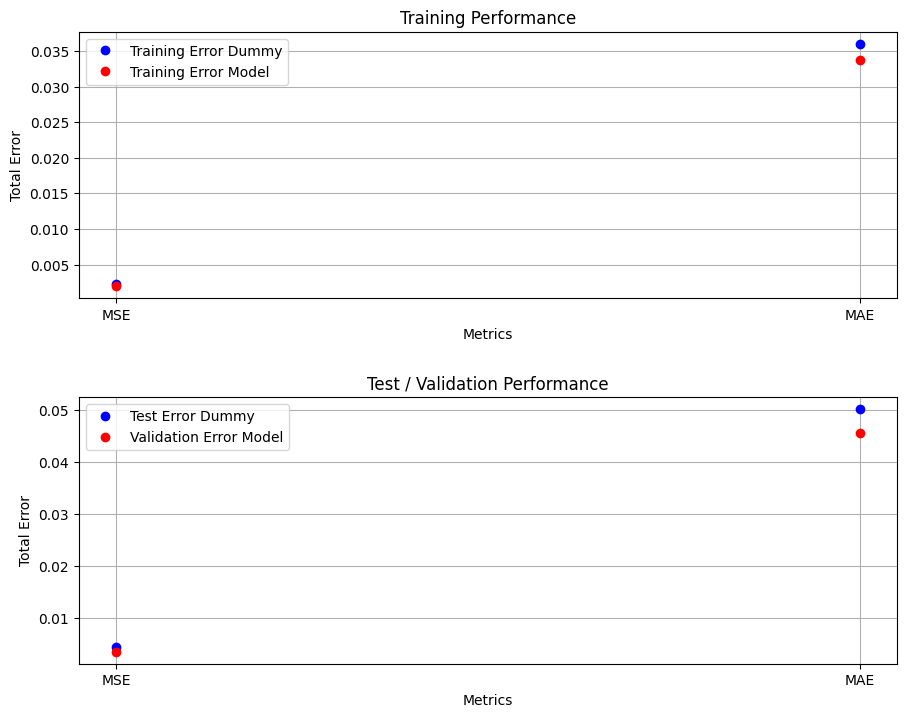

In [56]:
x = ['MSE', 'MAE']

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.tight_layout(pad=5.0)

axs[0].grid(True)
axs[0].set_title('Training Performance')
axs[0].set_ylabel('Total Error')
axs[0].set_xlabel('Metrics')
axs[0].plot(x, [mse_train_dummy, mae_train_dummy], 'ob', label='Training Error Dummy Model')
axs[0].plot(x, [mse_train[-1], mae_train[-1]], 'or', label='Training Error Model')
axs[0].legend()


axs[1].grid(True)
axs[1].set_title('Test / Validation Performance')
axs[1].set_ylabel('Total Error')
axs[1].set_xlabel('Metrics')
axs[1].plot(x, [mse_test_dummy, mae_test_dummy], 'ob', label='Test Error Dummy Model')
axs[1].plot(x, [mse_val[-1], mae_val[-1]], 'or', label='Validation Error Model')
axs[1].legend()